## Upload the dataset for creation of CNN, and check charasteristics

---



In [14]:
# to donwload the file you need to have you kaggle api token istalled the path should be ~/.kaggle/kaggle.json
# The kaggle.json file should look like this:
# {
#   "username": "your_username",
#   "key": "your_key"
# }
from kaggle.api.kaggle_api_extended import KaggleApi
import os

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the competition name (plant-seedlings-classification)
competition_name = 'plant-seedlings-classification'

# Specify the download path
download_path = './plant_seedlings'

# Download the competition dataset
api.competition_download_files(competition_name, path=download_path)

print(f"Dataset downloaded to {download_path}")


Dataset downloaded to ./plant_seedlings


In [16]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile(f'{download_path}/{competition_name}.zip', 'r') as zip_ref:
    zip_ref.extractall(download_path)

print("Dataset extracted.")

Dataset extracted.


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
from PIL import Image



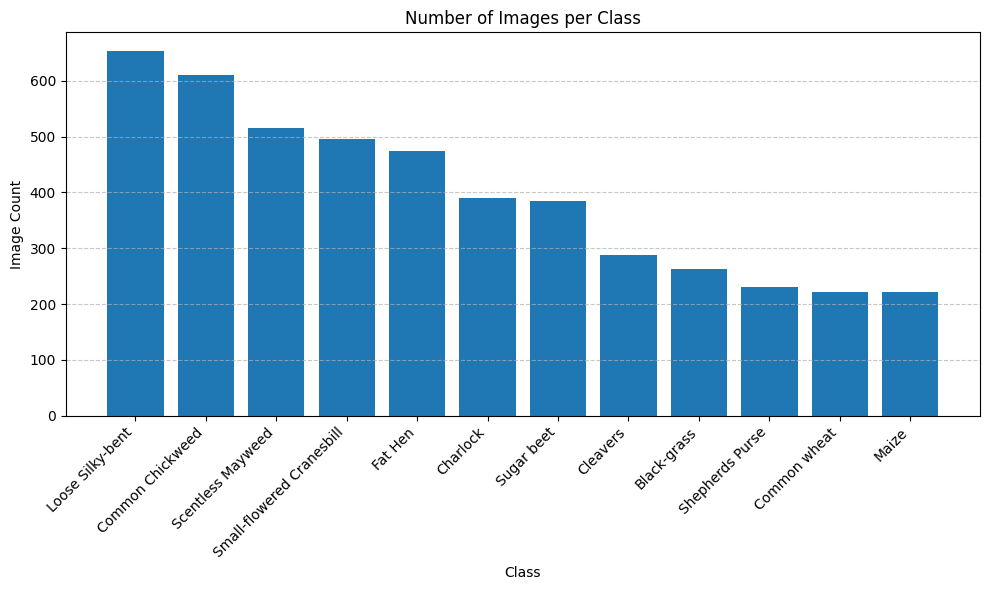

In [23]:
train_dir = "./plant_seedlings/train"
test_dir = "./plant_seedlings/test"

# Get list of subdirectories (classes) and count images
class_counts = {}
for cls_name in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls_name)
    if os.path.isdir(cls_path):
        image_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        class_counts[cls_name] = len(image_files)

# Create DataFrame and sort by count
df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Image Count'])
df_counts.sort_values(by='Image Count', ascending=False, inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(df_counts['Class'], df_counts['Image Count'])
ax.set_title("Number of Images per Class")
ax.set_xlabel("Class")
ax.set_ylabel("Image Count")
plt.xticks(rotation=45, ha='right', fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [28]:
import os
import random
from PIL import Image
import pandas as pd
import plotly.subplots as sp
import plotly.graph_objects as go
import nbformat as nb
import IPython

# Create DataFrame of image counts per class
df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Image Count'])
df_counts.sort_values(by='Image Count', ascending=False, inplace=True)

# Get class names
class_names = df_counts['Class'].tolist()

# Grid size (customize as needed)
n_rows, n_cols = 3, 4
max_images = n_rows * n_cols

# Initialize Plotly subplot figure
fig = sp.make_subplots(rows=n_rows, cols=n_cols,
                       subplot_titles=class_names[:max_images],
                       vertical_spacing=0.05, horizontal_spacing=0.03)

# Load and add images
img_idx = 0
for row in range(1, n_rows + 1):
    for col in range(1, n_cols + 1):
        if img_idx >= len(class_names):
            break
        cls = class_names[img_idx]
        cls_path = os.path.join(train_dir, cls)
        image_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        if image_files:
            img_file = random.choice(image_files)
            img_path = os.path.join(cls_path, img_file)
            try:
                with Image.open(img_path) as img:
                    fig.add_trace(
                        go.Image(z=img),
                        row=row, col=col
                    )
            except Exception as e:
                print(f"Error loading image: {img_path} ({e})")
        img_idx += 1

# Update layout for cleaner visuals
fig.update_layout(
    height=800, width=1200,
    title_text="Example Images from Each Class (Interactive)",
    showlegend=False,
    title_x=0.5,
    margin=dict(l=10, r=10, t=60, b=10)
)

# Remove axes for all subplots
for i in range(1, n_rows * n_cols + 1):
    fig['layout'][f'xaxis{i}']['visible'] = False
    fig['layout'][f'yaxis{i}']['visible'] = False

fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

We will also check balance of rgb colors, by plotting: RGB Channel Mean Distribution

Mean values per channel:
R    0.328815
G    0.289346
B    0.207304
dtype: float64
Standard deviation per channel:
R    0.034725
G    0.037108
B    0.050703
dtype: float64
Correlation between RGB channels:
          R         G         B
R  1.000000  0.882091  0.764380
G  0.882091  1.000000  0.858662
B  0.764380  0.858662  1.000000


<Figure size 1000x600 with 0 Axes>

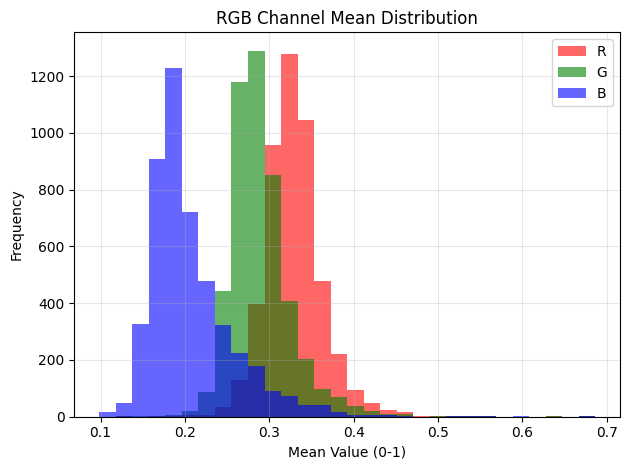

In [29]:
import numpy as np
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# Function to compute RGB means
def compute_rgb_means(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img_np = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
        r_mean = np.mean(img_np[:, :, 0])
        g_mean = np.mean(img_np[:, :, 1])
        b_mean = np.mean(img_np[:, :, 2])
        return r_mean, g_mean, b_mean
    except:
        return None

# Collect the RGB means for all images
rgb_means = []

for cls in os.listdir(train_dir):
    cls_dir = os.path.join(train_dir, cls)
    for img_name in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, img_name)
        means = compute_rgb_means(img_path)
        if means:
            rgb_means.append(means)

# Convert to DataFrame
df_rgb = pd.DataFrame(rgb_means, columns=['R', 'G', 'B'])

# Check the mean and std dev of each color channel
mean_rgb = df_rgb.mean()
std_rgb = df_rgb.std()

print(f"Mean values per channel:\n{mean_rgb}")
print(f"Standard deviation per channel:\n{std_rgb}")

# Check correlations between channels (to see if any channel is too similar or too different)
correlation_matrix = df_rgb.corr()
print(f"Correlation between RGB channels:\n{correlation_matrix}")

# Plot histograms of R, G, B with matching colors
plt.figure(figsize=(10, 6))
df_rgb.plot(kind='hist', bins=30, alpha=0.6, color=['red', 'green', 'blue'])
plt.title('RGB Channel Mean Distribution')
plt.xlabel("Mean Value (0-1)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


From the graph we see that we should not encounter grayscale pictures, rgb colors are distinclty distributed with red channel resulting in a mean value of 0.32 we can definately call it a dominating color, then we have green 0.29, pictures presumably present plants, and blue 0.21 which is a minority among the rgb set of colors. But to be shure we will check for greenscale pictures, they should have similar values of rgb colors in them. We will also identify grayscale images in 'L' mode. But mostly we will focus on checking which images can not be opened as RGB and then converted to RGB.

In [30]:
import os
from PIL import Image

corrupted_images = []

for cls in os.listdir(train_dir):
    cls_dir = os.path.join(train_dir, cls)
    for img_name in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, img_name)
        try:
            img = Image.open(img_path).convert('RGB')  # Try to open and convert to RGB
        except Exception as e:
            # If there's an error opening the image, add it to the corrupted list
            corrupted_images.append(img_path)
            print(f"Error opening {img_path}: {e}")

# Output the list of corrupted images
print(f"\nFound {len(corrupted_images)} corrupted or unreadable images.")
for img in corrupted_images:
    print(img)




Found 0 corrupted or unreadable images.


We will also check the sizes of the images

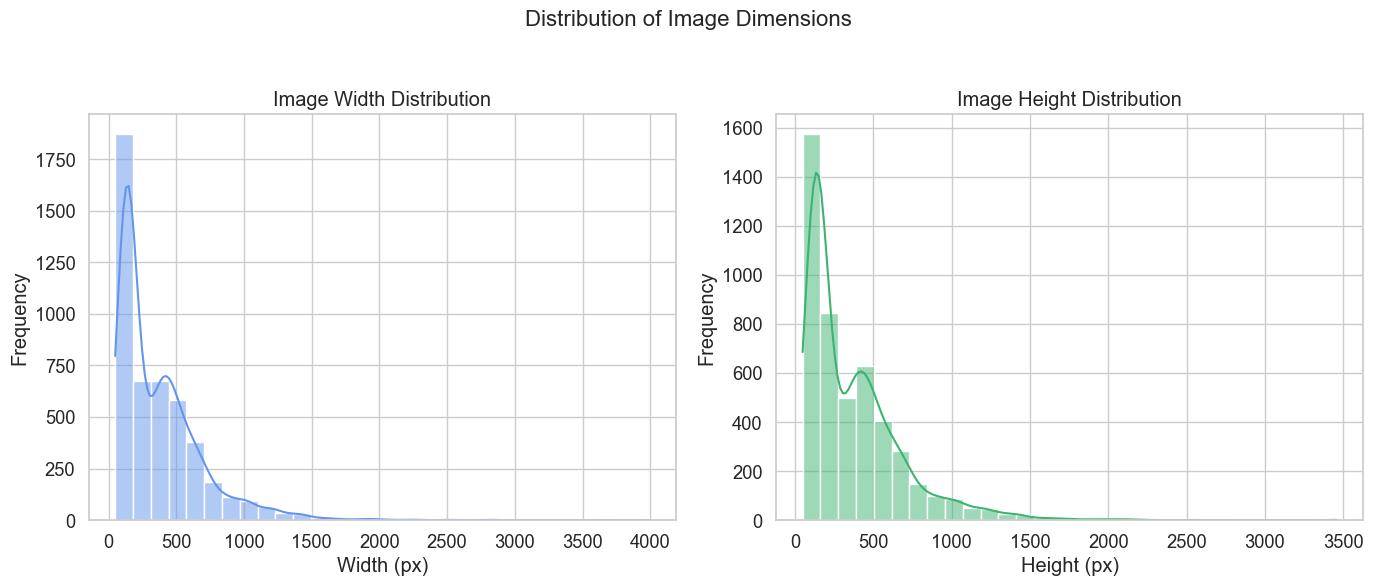

In [32]:
import os
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn theme for cleaner aesthetics
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

def collect_image_shapes(directory):
    shapes = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            try:
                with Image.open(image_path) as img:
                    shapes.append(img.size)  # (width, height)
            except Exception as e:
                print(f"Could not open image: {image_path} ({e})")
    return shapes

# Collect image dimensions and create DataFrame
image_shapes = collect_image_shapes(train_dir)
df_shapes = pd.DataFrame(image_shapes, columns=['width', 'height'])

# Create figure with Seaborn plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(data=df_shapes, x='width', bins=30, ax=axs[0], kde=True, color='cornflowerblue')
axs[0].set_title('Image Width Distribution')
axs[0].set_xlabel('Width (px)')
axs[0].set_ylabel('Frequency')

sns.histplot(data=df_shapes, x='height', bins=30, ax=axs[1], kde=True, color='mediumseagreen')
axs[1].set_title('Image Height Distribution')
axs[1].set_xlabel('Height (px)')
axs[1].set_ylabel('Frequency')

plt.suptitle('Distribution of Image Dimensions', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



Histograms show that most images range from 100 to 600 pixels in width and height, with a few large outliers exceeding 3000 pixels. This size variability suggests that resizing or normalization is needed before using the data in a CNN. We will also try to visualize the aspect ratio of images so that we know their shape.

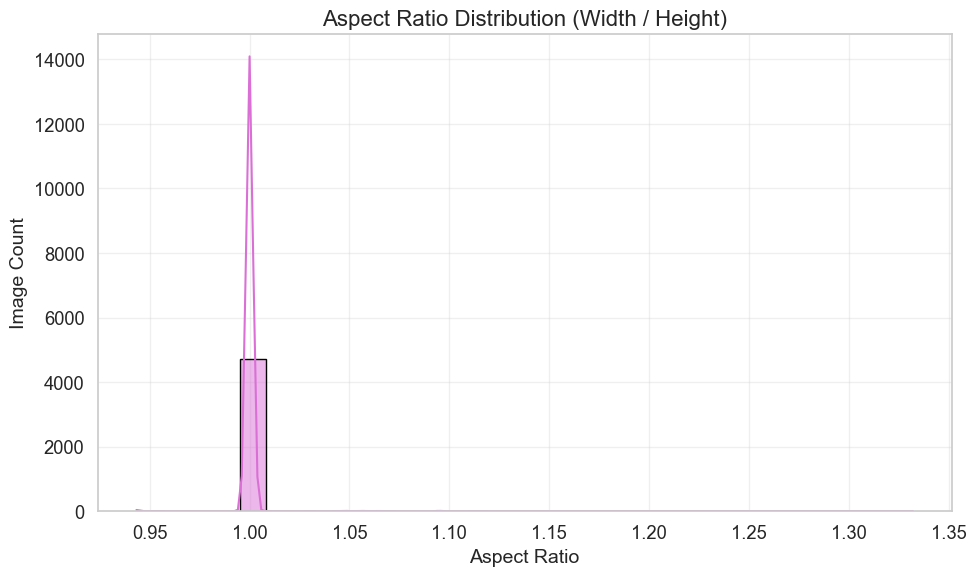

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate Aspect Ratio
df_shapes['aspect_ratio'] = df_shapes['width'] / df_shapes['height']

# Set Seaborn style for improved visuals
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create a figure with custom size
plt.figure(figsize=(10, 6))

# Plot histogram of aspect ratios using Seaborn's histplot
sns.histplot(df_shapes['aspect_ratio'], bins=30, color='orchid', kde=True, edgecolor='black')

# Customize plot with titles and labels
plt.title("Aspect Ratio Distribution (Width / Height)", fontsize=16)
plt.xlabel("Aspect Ratio", fontsize=14)
plt.ylabel("Image Count", fontsize=14)

# Show grid with a soft transparency
plt.grid(alpha=0.3)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


A significant majority of the images have an aspect ratio close to 1, meaning that most of the images are square or nearly square. So knowing that the dataset primarily consists of square images, it is okay to standardize all images to a square resolution when preprocessing. Mostly because there are slim chances of changing the content of the picture.


## Preprocessing of the images


We will convert all images to RGB and resize them

In [36]:
from tensorflow.keras.preprocessing.image import img_to_array
import os

# Parameters
IMG_SIZE = 96
DATASET_DIR = "./plant_seedlings/train"

# Containers
images = []
labels = []
class_names = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])

# Iterate through class folders and load images
for class_name in class_names:
    class_dir = os.path.join(DATASET_DIR, class_name)
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        try:
            # Open image, convert to RGB and resize
            img = Image.open(img_path).convert("RGB")
            img = img.resize((IMG_SIZE, IMG_SIZE))
            img_array = img_to_array(img) / 255.0  # Normalize to 0–1
            images.append(img_array)
            labels.append(class_name)
        except Exception as e:
            print(f"Skipping file {img_path}: {e}")

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

print("Images loaded and resized")
print(f"Image shape: {X.shape}")
print(f"Unique classes: {len(np.unique(y))}")


Images loaded and resized
Image shape: (4750, 96, 96, 3)
Unique classes: 12


We have also resized pictures to 224x224 becasue this is the samllest size and that most pictures have. We do it so that we have consistent input, and memory efficiency enhanced. Later we will convert string labels meaning classes of plants into integer indices for the CNN and then apply one-hot encoding to represent these labels as binary vectors. Then we will split the dataset into training, validation, and test sets using train_test_split, with stratified sampling to ensure class distribution is preserved in each split.

In [38]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Function to create label mappings and encode labels
def encode_labels(y):
    label_to_index = {label: idx for idx, label in enumerate(np.unique(y))}
    y_encoded = np.array([label_to_index[label] for label in y])
    return label_to_index, y_encoded

# One-hot encoding of labels
def one_hot_encode(y_encoded, num_classes):
    return to_categorical(y_encoded, num_classes=num_classes)

# Split the data into train, validation, and test sets
def split_data(X, y_categorical):
    X_train, X_test1, y_train, y_test1 = train_test_split(
        X, y_categorical, test_size=0.30, stratify=y_categorical, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_test1, y_test1, test_size=0.50, stratify=y_test1, random_state=42
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

# Main execution
label_to_index, y_encoded = encode_labels(y)
y_categorical = one_hot_encode(y_encoded, num_classes=len(label_to_index))

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y_categorical)

# Print shapes
print("Labels encoded and data split finished.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")


Labels encoded and data split finished.
X_train shape: (3325, 96, 96, 3)
y_train shape: (3325, 12)
X_val shape:   (712, 96, 96, 3)
y_val shape:   (712, 12)
X_test shape:  (713, 96, 96, 3)
y_test shape:  (713, 12)


Later we will processes images by applying green color segmentation, Gaussian blur, and normalization to isolate relevant green regions, making them suitable for CNN training. Since we want to clasify plants which are green. These steps will ensure that the images are cleaned, standardized, and that they focus on the desired features (green areas), which can enhance model performance for tasks like object recognition in plant-related datasets. What we want is sharp edges and close 0-1 color palette with distinction for green.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


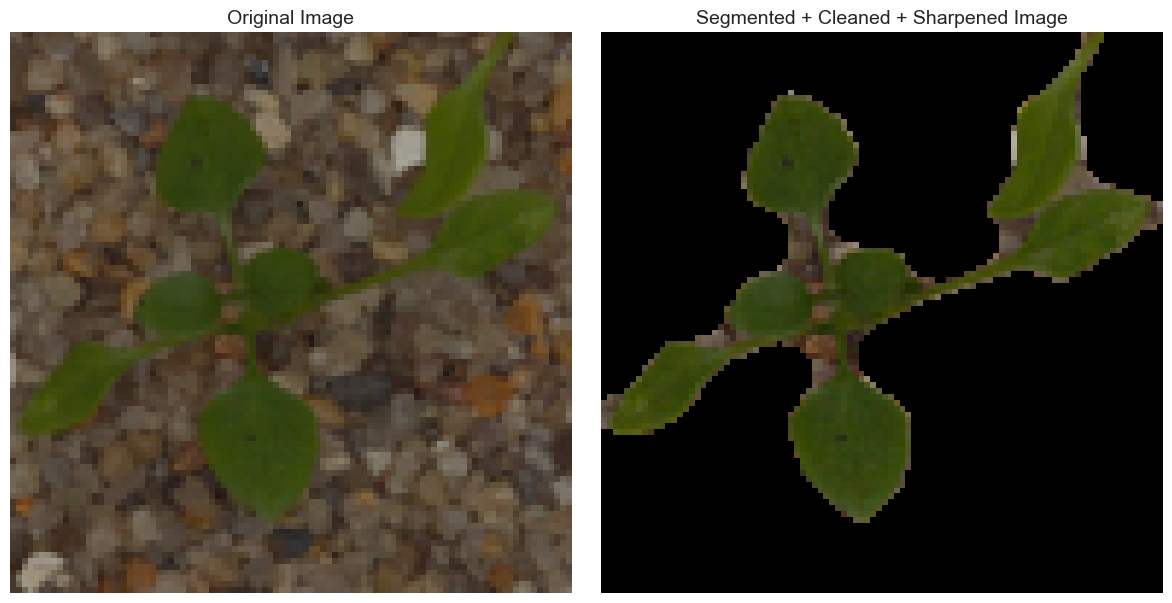

In [42]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# --- Settings for Green Segmentation ---
lower_green = (25, 40, 50)
upper_green = (75, 255, 255)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))

# --- Sharpening function using unsharp masking ---
def sharpen_image(img):
    # Apply a Gaussian blur to create a blurred version of the image
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    # Sharpening by subtracting the blurred image from the original
    sharpened = cv2.addWeighted(img, 1.5, blurred, -0.5, 0)
    return sharpened

# --- Preprocessing function ---
def preprocess_images(X):
    preprocessed = []
    for img in X:
        # 1. Convert to uint8 (0–255)
        img_uint8 = (img * 255).astype(np.uint8)

        # 2. Optional resize (images are 224x224 in this case)
        resize_img = img_uint8

        # 3. Apply Gaussian blur for smoothing
        Gblur_img = cv2.GaussianBlur(resize_img, (3, 3), 0)

        # 4. Convert to HSV for easier color segmentation
        hsv_img = cv2.cvtColor(Gblur_img, cv2.COLOR_RGB2HSV)  # RGB -> HSV

        # 5. Segment the green regions
        mask = cv2.inRange(hsv_img, lower_green, upper_green)

        # 6. Morphological cleaning (removing noise)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # 7. Boolean mask to select green regions
        bMask = mask > 0

        # 8. Apply the mask to the image (keep only non-green parts)
        clearImg = np.zeros_like(resize_img, np.uint8)
        clearImg[bMask] = resize_img[bMask]

        # 9. Normalize the image (0–1)
        clearImg_float = clearImg.astype(np.float32) / 255.0

        # 10. Sharpen the edges of the image
        sharpened_img = sharpen_image(clearImg_float)

        preprocessed.append(sharpened_img)

    return np.asarray(preprocessed)

# --- Preprocessing the data (example for X_train) ---
X_train_cleaned = preprocess_images(X_train)
X_val_cleaned = preprocess_images(X_val)
X_test_cleaned = preprocess_images(X_test)

# --- Display a random example of original and processed image ---
def display_random_image(X_original, X_processed):
    # Random index for image selection
    idx = np.random.randint(0, len(X_original))

    # Fetch original and processed images
    original_img = X_original[idx]
    processed_img = X_processed[idx]

    # Create figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image", fontsize=14)
    axes[0].axis('off')  # Hide axes

    # Display the processed image
    axes[1].imshow(processed_img)
    axes[1].set_title("Segmented + Cleaned + Sharpened Image", fontsize=14)
    axes[1].axis('off')  # Hide axes

    # Adjust layout for better presentation
    plt.tight_layout()
    plt.show()

# Call the function to display a random image
display_random_image(X_train, X_train_cleaned)


In [43]:
print(f"Cleaned training shape: {X_train_cleaned.shape}")
print(f"Cleaned validation shape: {X_val_cleaned.shape}")
print(f"Cleaned test shape: {X_test_cleaned.shape}")


Cleaned training shape: (3325, 96, 96, 3)
Cleaned validation shape: (712, 96, 96, 3)
Cleaned test shape: (713, 96, 96, 3)


# CNN model build


Looking for the right values of strides pools etc.

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Input

def build_variant_model(
    input_shape,
    num_classes=12,
    filters=[32, 64, 128, 128],
    strides=2,
    padding='same',
    pool_type='max'  # or 'avg'
):
    model = Sequential()
    model.add(Input(shape=input_shape))

    for f in filters:
        model.add(Conv2D(f, (3, 3), activation='relu', padding=padding))
        model.add(BatchNormalization())
        if pool_type == 'max':
            model.add(MaxPooling2D(pool_size=(2, 2), strides=strides))
        else:
            model.add(AveragePooling2D(pool_size=(2, 2), strides=strides))

    model.add(Flatten())

    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))

    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))

    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation='softmax'))

    return model


Training and comparing different variations

In [47]:
import os
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

variants = {
    'Original': {},
    'More Filters': {'filters': [64, 128, 256, 256]},
    'Larger Stride': {'strides': 3},
    'Valid Padding': {'padding': 'valid'},
    'Average Pooling': {'pool_type': 'avg'},
}

results = {}
training_times = {}

# Make sure the base model directory exists
base_model_dir = 'models'
os.makedirs(base_model_dir, exist_ok=True)

for name, params in variants.items():
    print(f"\nTraining: {name}")
    model = build_variant_model(
        input_shape=X_train_cleaned.shape[1:],
        num_classes=y_train.shape[1],
        **params
    )

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    start_time = time.time()

    history = model.fit(
        X_train_cleaned, y_train,
        validation_data=(X_val_cleaned, y_val),
        epochs=15,
        batch_size=8,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    end_time = time.time()
    elapsed_time = end_time - start_time

    results[name] = history.history
    training_times[name] = elapsed_time
    print(f"Training time for {name}: {elapsed_time:.2f} seconds")

    # Save the model
    safe_name = name.replace(" ", "_")  # e.g., "More Filters" -> "More_Filters"
    model_path = os.path.join(base_model_dir, safe_name)
    model.save(model_path)
    print(f"Model saved to {model_path}")



Training: Original
Epoch 1/15
416/416 [==============================] - 18s 40ms/step - loss: 2.2870 - accuracy: 0.2436 - val_loss: 4.6432 - val_accuracy: 0.0604 - lr: 0.0010
Epoch 2/15
416/416 [==============================] - 15s 36ms/step - loss: 1.7598 - accuracy: 0.3889 - val_loss: 1.4391 - val_accuracy: 0.4972 - lr: 0.0010
Epoch 3/15
416/416 [==============================] - 17s 40ms/step - loss: 1.6283 - accuracy: 0.4430 - val_loss: 1.2581 - val_accuracy: 0.5983 - lr: 0.0010
Epoch 4/15
416/416 [==============================] - 15s 35ms/step - loss: 1.5415 - accuracy: 0.4704 - val_loss: 1.3538 - val_accuracy: 0.5758 - lr: 0.0010
Epoch 5/15
415/416 [============================>.] - ETA: 0s - loss: 1.4518 - accuracy: 0.4889
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
416/416 [==============================] - 15s 36ms/step - loss: 1.4506 - accuracy: 0.4893 - val_loss: 1.4146 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/15
416/416 [==============

INFO:tensorflow:Assets written to: models/Original/assets


Model saved to models/Original

Training: More Filters
Epoch 1/15
416/416 [==============================] - 41s 99ms/step - loss: 2.2805 - accuracy: 0.2352 - val_loss: 5.5529 - val_accuracy: 0.0534 - lr: 0.0010
Epoch 2/15
416/416 [==============================] - 40s 97ms/step - loss: 1.8333 - accuracy: 0.3817 - val_loss: 1.6836 - val_accuracy: 0.4059 - lr: 0.0010
Epoch 3/15
416/416 [==============================] - 40s 96ms/step - loss: 1.6407 - accuracy: 0.4256 - val_loss: 1.4642 - val_accuracy: 0.5169 - lr: 0.0010
Epoch 4/15
416/416 [==============================] - 41s 98ms/step - loss: 1.5448 - accuracy: 0.4650 - val_loss: 1.1715 - val_accuracy: 0.6124 - lr: 0.0010
Epoch 5/15
416/416 [==============================] - 38s 92ms/step - loss: 1.4510 - accuracy: 0.4893 - val_loss: 1.2056 - val_accuracy: 0.5955 - lr: 0.0010
Epoch 6/15
416/416 [==============================] - ETA: 0s - loss: 1.3933 - accuracy: 0.5158
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000500000

INFO:tensorflow:Assets written to: models/More_Filters/assets


Model saved to models/More_Filters

Training: Larger Stride
Epoch 1/15
416/416 [==============================] - 7s 17ms/step - loss: 2.3252 - accuracy: 0.2430 - val_loss: 2.8950 - val_accuracy: 0.1910 - lr: 0.0010
Epoch 2/15
416/416 [==============================] - 7s 16ms/step - loss: 1.8600 - accuracy: 0.3540 - val_loss: 1.4567 - val_accuracy: 0.5183 - lr: 0.0010
Epoch 3/15
416/416 [==============================] - 7s 17ms/step - loss: 1.6407 - accuracy: 0.4337 - val_loss: 2.2898 - val_accuracy: 0.3652 - lr: 0.0010
Epoch 4/15
416/416 [==============================] - 7s 18ms/step - loss: 1.5140 - accuracy: 0.4731 - val_loss: 1.4329 - val_accuracy: 0.5253 - lr: 0.0010
Epoch 5/15
416/416 [==============================] - 8s 20ms/step - loss: 1.4156 - accuracy: 0.5047 - val_loss: 2.6528 - val_accuracy: 0.3567 - lr: 0.0010
Epoch 6/15
416/416 [==============================] - 7s 17ms/step - loss: 1.3375 - accuracy: 0.5420 - val_loss: 1.0725 - val_accuracy: 0.6334 - lr: 0.0010
Epoc

INFO:tensorflow:Assets written to: models/Larger_Stride/assets


Model saved to models/Larger_Stride

Training: Valid Padding
Epoch 1/15
416/416 [==============================] - 12s 27ms/step - loss: 2.2041 - accuracy: 0.2725 - val_loss: 4.3111 - val_accuracy: 0.1461 - lr: 0.0010
Epoch 2/15
416/416 [==============================] - 12s 28ms/step - loss: 1.7764 - accuracy: 0.3877 - val_loss: 1.3641 - val_accuracy: 0.5126 - lr: 0.0010
Epoch 3/15
416/416 [==============================] - 11s 27ms/step - loss: 1.6131 - accuracy: 0.4424 - val_loss: 2.3774 - val_accuracy: 0.3708 - lr: 0.0010
Epoch 4/15
416/416 [==============================] - 11s 25ms/step - loss: 1.5241 - accuracy: 0.4677 - val_loss: 1.2114 - val_accuracy: 0.5787 - lr: 0.0010
Epoch 5/15
416/416 [==============================] - 11s 26ms/step - loss: 1.3784 - accuracy: 0.5107 - val_loss: 1.2092 - val_accuracy: 0.5562 - lr: 0.0010
Epoch 6/15
416/416 [==============================] - 12s 28ms/step - loss: 1.3187 - accuracy: 0.5414 - val_loss: 1.0039 - val_accuracy: 0.6629 - lr: 0.00

INFO:tensorflow:Assets written to: models/Valid_Padding/assets


Model saved to models/Valid_Padding

Training: Average Pooling
Epoch 1/15
416/416 [==============================] - 14s 32ms/step - loss: 2.1749 - accuracy: 0.2782 - val_loss: 5.9018 - val_accuracy: 0.0604 - lr: 0.0010
Epoch 2/15
416/416 [==============================] - 13s 31ms/step - loss: 1.7590 - accuracy: 0.3994 - val_loss: 2.0076 - val_accuracy: 0.3315 - lr: 0.0010
Epoch 3/15
416/416 [==============================] - 13s 31ms/step - loss: 1.6124 - accuracy: 0.4409 - val_loss: 3.3295 - val_accuracy: 0.3160 - lr: 0.0010
Epoch 4/15
415/416 [============================>.] - ETA: 0s - loss: 1.5075 - accuracy: 0.4807
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
416/416 [==============================] - 13s 31ms/step - loss: 1.5091 - accuracy: 0.4803 - val_loss: 11.3132 - val_accuracy: 0.1868 - lr: 0.0010
Epoch 5/15
416/416 [==============================] - 13s 31ms/step - loss: 1.3745 - accuracy: 0.5278 - val_loss: 1.0409 - val_accuracy: 0.6292 - l

INFO:tensorflow:Assets written to: models/Average_Pooling/assets


Model saved to models/Average_Pooling


Plotting and analysing

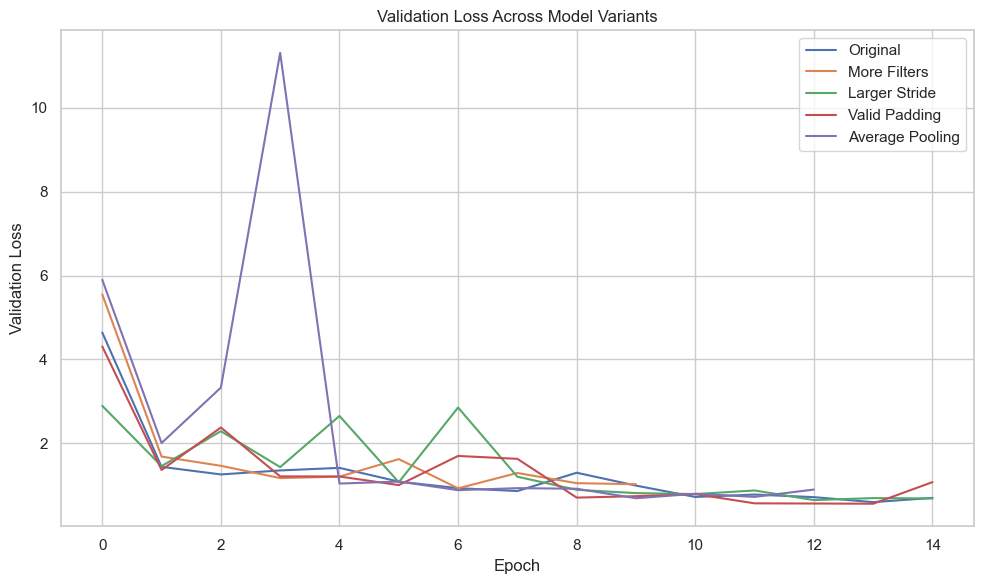

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for name, history in results.items():
    val_loss = history.get('val_loss')
    if val_loss:  # Make sure it exists
        plt.plot(val_loss, label=name)

plt.title('Validation Loss Across Model Variants')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Change	Possible Impact
More filters	May improve accuracy but increase computation.
Larger strides	Reduces spatial resolution faster — may lose detail.
Valid padding	Shrinks feature maps — can lose edge info.
Average pooling	May retain smoother features vs. max-pooling (sharper features).

## Build of probably good model


In [53]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

ins = X_train_cleaned.shape[1:]

# Modified Best Model (adjustments to prevent overfitting and increase depth)
def build_no_callbacks_model(input_shape=(ins[0], ins[1], ins[2]), num_classes=12):
    model = Sequential()

    # 1st Convolutional Block
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # 2nd Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # 3rd Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # 4th Convolutional Block (additional block to add more depth)
    model.add(Conv2D(128, (3, 3), activation='relu', padding='valid'))  # No padding
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Flatten before Dense layers
    model.add(Flatten())

    # Fully Connected Layers
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))  # Increased dropout to 0.3 for more regularization

    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))  # Increased units in dense layer
    model.add(Dropout(0.3))  # Dropout to avoid overfitting

    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))  # Dropout at the final dense layer

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model


## Running the probable model but without callbacks


In [57]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = build_no_callbacks_model()

from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

history1 = model.fit(
    X_train_cleaned, y_train,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    batch_size=8
)


Epoch 1/30
416/416 [==============================] - 13s 31ms/step - loss: 2.1982 - accuracy: 0.2683 - precision_1: 0.4453 - recall_1: 0.1053 - val_loss: 3.8938 - val_accuracy: 0.1110 - val_precision_1: 0.1149 - val_recall_1: 0.0941
Epoch 2/30
416/416 [==============================] - 13s 30ms/step - loss: 1.7318 - accuracy: 0.4048 - precision_1: 0.5675 - recall_1: 0.2250 - val_loss: 2.0908 - val_accuracy: 0.4031 - val_precision_1: 0.4969 - val_recall_1: 0.3357
Epoch 3/30
416/416 [==============================] - 12s 30ms/step - loss: 1.5747 - accuracy: 0.4586 - precision_1: 0.6101 - recall_1: 0.2749 - val_loss: 1.1766 - val_accuracy: 0.5997 - val_precision_1: 0.6901 - val_recall_1: 0.4817
Epoch 4/30
416/416 [==============================] - 12s 30ms/step - loss: 1.4307 - accuracy: 0.4965 - precision_1: 0.6292 - recall_1: 0.3185 - val_loss: 1.1968 - val_accuracy: 0.6250 - val_precision_1: 0.6873 - val_recall_1: 0.5309
Epoch 5/30
416/416 [==============================] - 12s 30ms/s

## Illustration of convolution results of a specific Layer[1,2,3]no 1 is specified now it the code, visualisation of feature maps

In [58]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.output_shape)

0 conv2d_36 (None, 96, 96, 32)
1 batch_normalization_63 (None, 96, 96, 32)
2 max_pooling2d_32 (None, 48, 48, 32)
3 conv2d_37 (None, 48, 48, 64)
4 batch_normalization_64 (None, 48, 48, 64)
5 max_pooling2d_33 (None, 24, 24, 64)
6 conv2d_38 (None, 24, 24, 128)
7 batch_normalization_65 (None, 24, 24, 128)
8 max_pooling2d_34 (None, 12, 12, 128)
9 conv2d_39 (None, 10, 10, 128)
10 batch_normalization_66 (None, 10, 10, 128)
11 max_pooling2d_35 (None, 5, 5, 128)
12 flatten_9 (None, 3200)
13 batch_normalization_67 (None, 3200)
14 dense_36 (None, 512)
15 dropout_27 (None, 512)
16 batch_normalization_68 (None, 512)
17 dense_37 (None, 256)
18 dropout_28 (None, 256)
19 batch_normalization_69 (None, 256)
20 dense_38 (None, 128)
21 dropout_29 (None, 128)
22 dense_39 (None, 12)


1/1 [==============================] - 0s 63ms/step


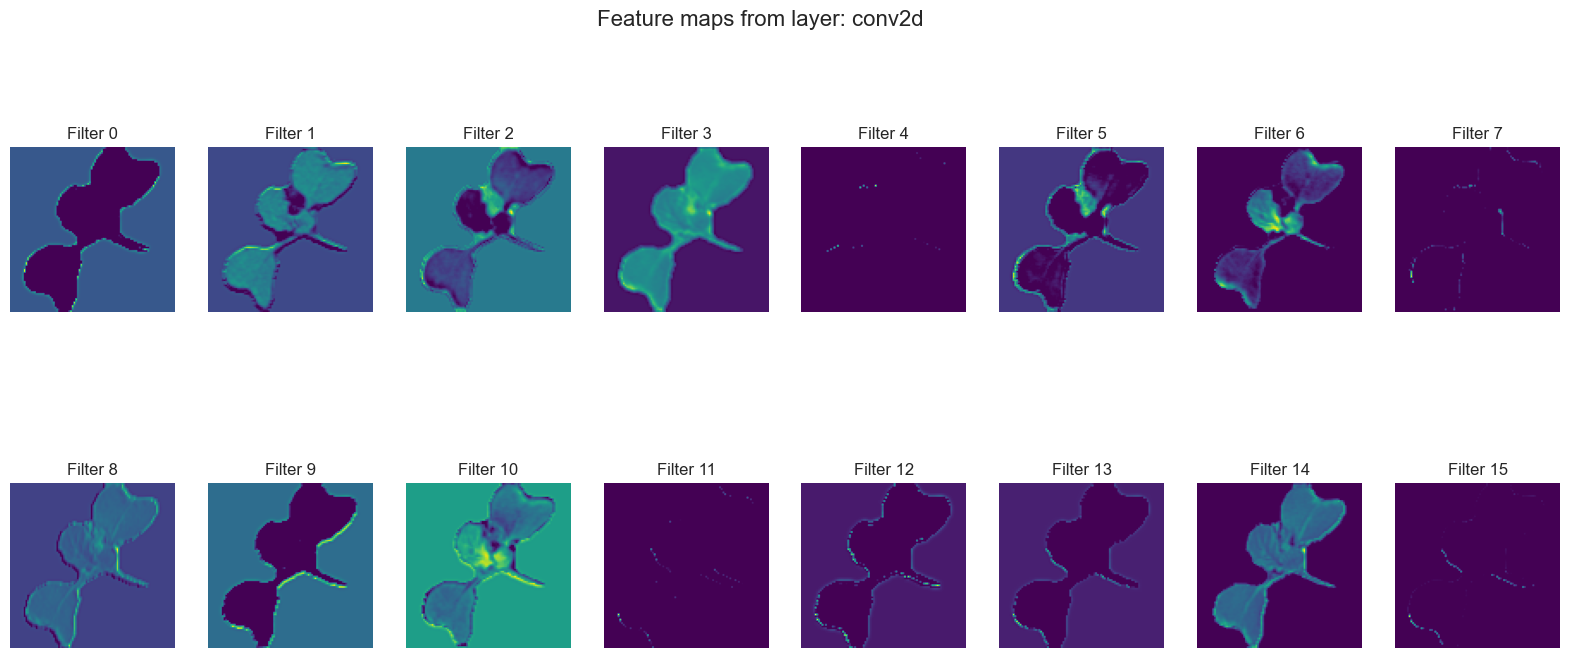

In [59]:

import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import numpy as np


# Pick a sample image (reshape if needed)
sample_image = X_val_cleaned[0]  # shape: (H, W, C)
sample_image = np.expand_dims(sample_image, axis=0)  # add batch dimension

# Pick a layer to visualize (e.g., 'conv2d' or layer index)
layer_name = 'conv2d'  # or model.layers[1].name
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[1].output)

# Get feature maps
feature_maps = intermediate_layer_model.predict(sample_image)

# Plot the feature maps
num_filters = feature_maps.shape[-1]
size = feature_maps.shape[1]

plt.figure(figsize=(20, 8))
for i in range(min(num_filters, 16)):  # Show first 16 filters
    ax = plt.subplot(2, 8, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Filter {i}')
plt.suptitle(f"Feature maps from layer: {layer_name}", fontsize=16)
plt.show()


Insights:

## Accuracy of the probable model without callbacks

In [60]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 [==============================] - 1s 27ms/step - loss: 0.7355 - accuracy: 0.7966 - precision_1: 0.8349 - recall_1: 0.7588


23/23 [==============================] - 1s 27ms/step


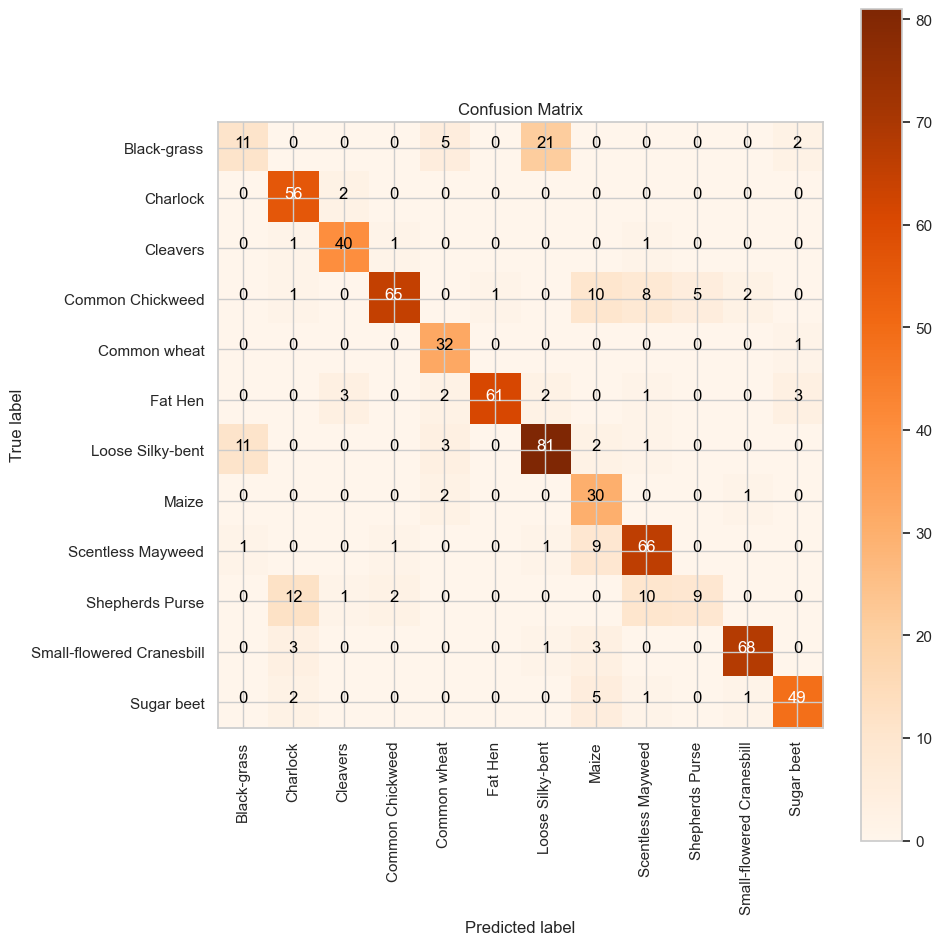

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):  # Change the colormap here
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}', horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)  # Predicted classes (0-based index)
trueY = np.argmax(y_test, axis=1)        # True labels (0-based index)

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Reverse the label-to-index mapping ---
# If label_to_index maps {class_name: index}, reverse it to {index: class_name}
index_to_label = {v: k for k, v in label_to_index.items()}

# --- Get class names for plotting ---
categ = [index_to_label[i] for i in range(len(index_to_label))]

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False, cmap=plt.cm.Oranges)  # Change colormap here


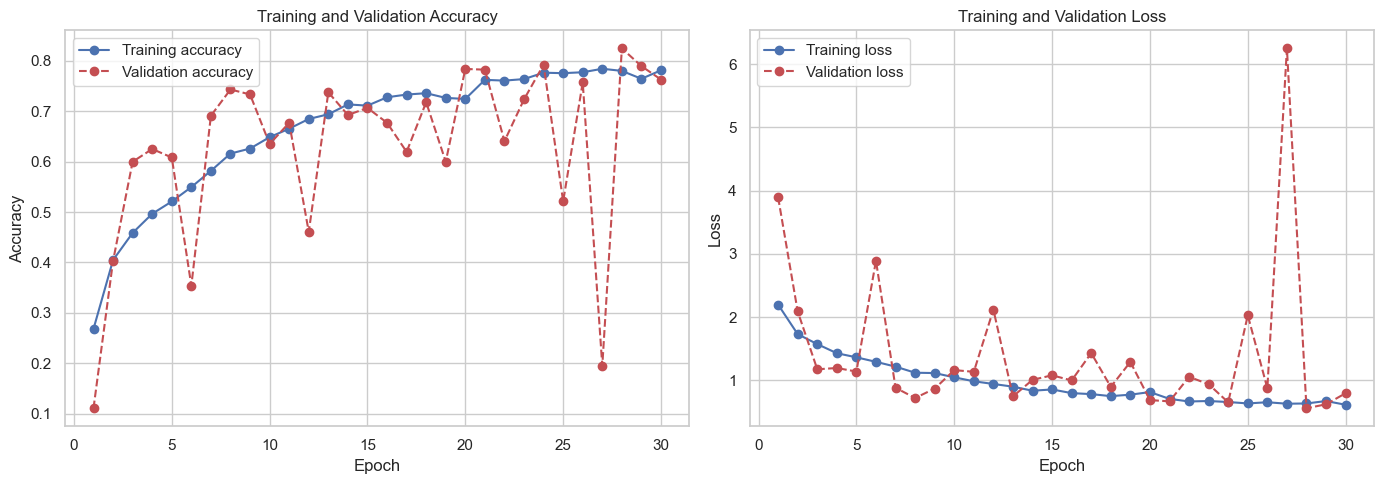

In [63]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro--', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro--', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_accuracy_and_loss(history1)

There is definately some overfitting because:
We will now introduce such us Early Stopping and

## Running the model with callbacks

In [65]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

model = build_no_callbacks_model()

from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

history2 = model.fit(
    X_train_cleaned, y_train,
    validation_data=(X_val_cleaned, y_val),
    epochs=50,
    batch_size=8,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
416/416 [==============================] - 14s 33ms/step - loss: 2.2395 - accuracy: 0.2556 - precision_2: 0.4214 - recall_2: 0.0935 - val_loss: 4.2111 - val_accuracy: 0.0969 - val_precision_2: 0.0945 - val_recall_2: 0.0899 - lr: 0.0010
Epoch 2/50
415/416 [============================>.] - ETA: 0s - loss: 1.8059 - accuracy: 0.3807 - precision_2: 0.5330 - recall_2: 0.2018

KeyboardInterrupt: 

 Interpretation:

✅ High precision and recall on validation data suggests the model is generalizing well and not overfitting.

✅ Validation accuracy > training accuracy can mean regularization (e.g., dropout, early stopping) helped prevent overfitting.

✅ Low validation loss confirms the model is confident and consistent in its predictions.

📉 Early Stopping
The message Restoring model weights from the end of the best epoch: 29 confirms that early stopping restored the best weights, avoiding any overfitting in the final epoch.
We then increased the number of Epochs to 50 so that we can better observe the Early Stopping callback behaviour. The program this time restorted weights at 35th epoch. While at the same time we increased patience the acuracy increased from 0.85-0.88

## Evaluation of accuracy

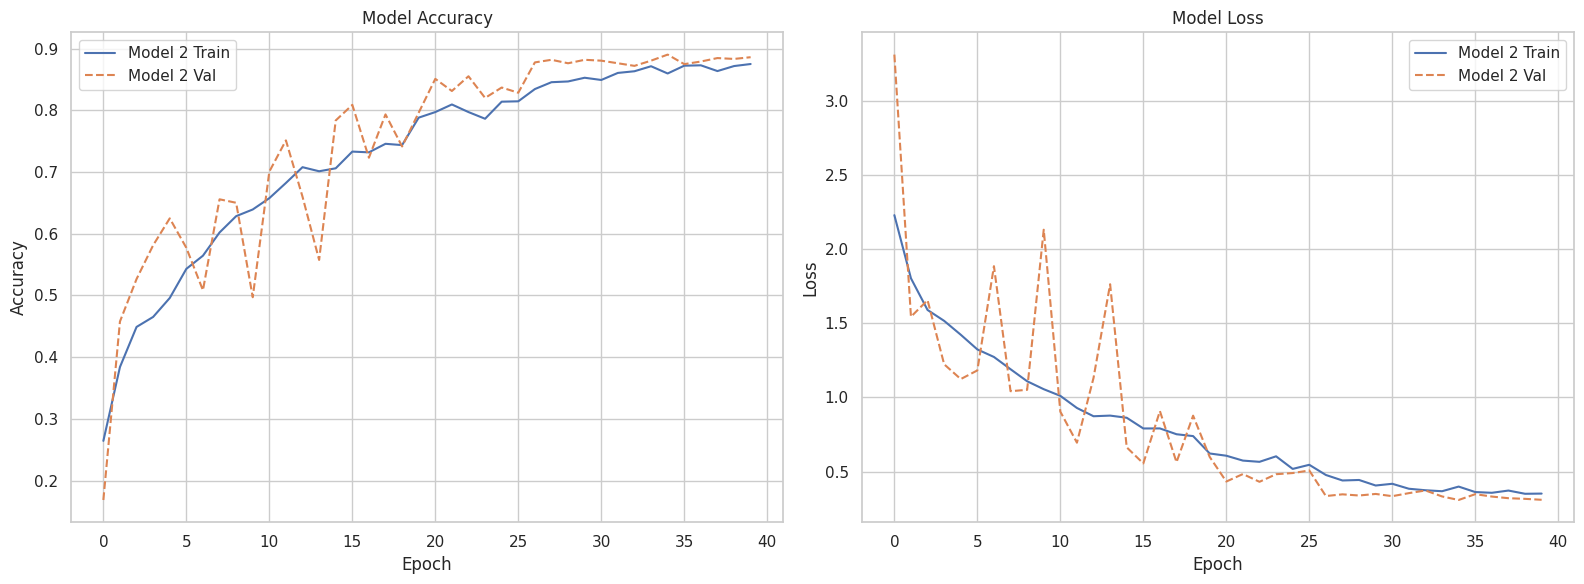

In [ ]:
import matplotlib.pyplot as plt

# Function to extract metrics for plotting
def extract_metrics(history):
    return (
        history.history['accuracy'],
        history.history['val_accuracy'],
        history.history['loss'],
        history.history['val_loss'],
    )

# Assuming these are available in your session already
histories = {
    #"Model 1": history1.history if 'history1' in globals() else None,
    "Model 2": history2.history if 'history2' in globals() else None
}

# Plotting
plt.figure(figsize=(16, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
for name, h in histories.items():
    if h:  # Check if history is available
        plt.plot(h['accuracy'], label=f'{name} Train')
        plt.plot(h['val_accuracy'], linestyle='--', label=f'{name} Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8675 - loss: 0.5064 - precision: 0.8845 - recall: 0.8504


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step


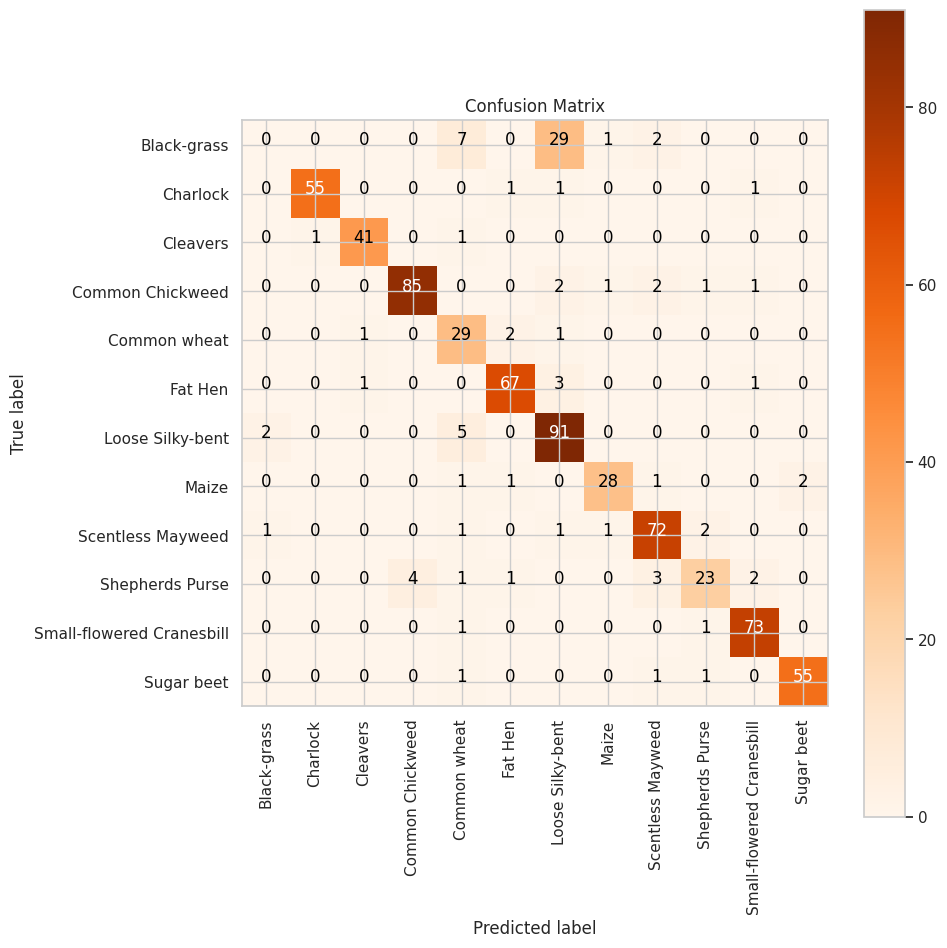

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):  # Change the colormap here
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}', horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)  # Predicted classes (0-based index)
trueY = np.argmax(y_test, axis=1)        # True labels (0-based index)

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Reverse the label-to-index mapping ---
# If label_to_index maps {class_name: index}, reverse it to {index: class_name}
index_to_label = {v: k for k, v in label_to_index.items()}

# --- Get class names for plotting ---
categ = [index_to_label[i] for i in range(len(index_to_label))]

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False, cmap=plt.cm.Oranges)  # Change colormap here


In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8302 - loss: 0.6140 - precision: 0.8449 - recall: 0.8259


## Adding data-augmentation and running models with it

here I will implement model with data augmentation

In [1]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Data Augmentation for training set only
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to your data (optional, depending on data type)
datagen.fit(X_train_cleaned)

# Create the model
model = build_no_callbacks_model()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Train the model using the augmented data
history2 = model.fit(
    datagen.flow(X_train_cleaned, y_train, batch_size=8),
    validation_data=(X_val_cleaned, y_val),
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    steps_per_epoch=len(X_train_cleaned) // 8
)


NameError: name 'X_train_cleaned' is not defined

## Running the pretrained Resnet50 model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define input shape
input_shape = X_train_cleaned.shape[1:]  # (height, width, channels)
num_classes = 12  # change as needed

# Load ResNet50 base model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

# Freeze base model layers to prevent training initially
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history_resnet = model.fit(
    X_train_cleaned, y_train,
    validation_data=(X_val_cleaned, y_val),
    epochs=30,
    batch_size=8,
    callbacks=[early_stop, reduce_lr]
)


In [ ]:
results = model.evaluate(X_test_cleaned, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.7309 - loss: 0.7712 - precision_24: 0.8015 - recall_24: 0.6828


## Results of pretrained model

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2101']
Received: inputs=Tensor(shape=(32, 96, 96, 3))
  warnings.warn(msg)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step
Accuracy:  0.739130437374115
Precision:  0.8033058047294617
Recall:  0.6816269159317017


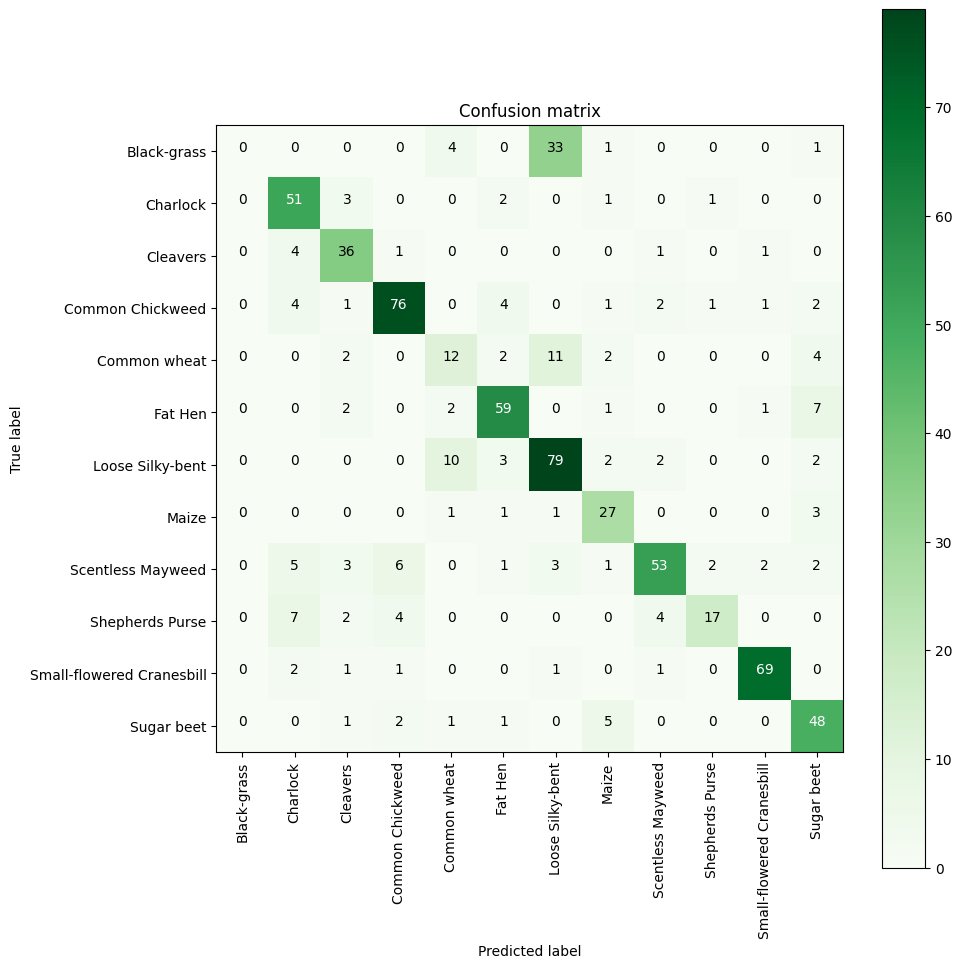

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):  # Change the colormap here
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}', horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test_cleaned)
predYClasses = np.argmax(predY, axis=1)  # Predicted classes (0-based index)
trueY = np.argmax(y_test, axis=1)        # True labels (0-based index)

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Reverse the label-to-index mapping ---
# If label_to_index maps {class_name: index}, reverse it to {index: class_name}
index_to_label = {v: k for k, v in label_to_index.items()}

# --- Get class names for plotting ---
categ = [index_to_label[i] for i in range(len(index_to_label))]

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False, cmap=plt.cm.Oranges)  # Change colormap here


# Comparison of results from different approaches